# App Response time per application per source (P1)

Here we testing the different models for the p1 report with latest architecture (aggregated data to one day)

## Data preperation

In [1]:

from pyspark.sql import SQLContext
import sys
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession


from pyspark.sql import SparkSession
import pymysql
from tqdm import tqdm
import config

# initialise sparkContext
spark1 = SparkSession.builder \
        .master(config.sp_master) \
        .appName(config.sp_appname) \
        .config('spark.executor.memory', config.sp_memory) \
        .config("spark.cores.max", config.sp_cores) \
        .getOrCreate()
    
sc = spark1.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

In [2]:
df = sqlContext.read.parquet('./../datas/appid_datapoint_parquet1')

In [3]:
ap_list = ['DNS', 'DHCP', 'Radius', 'Kerberos', 'LDAP']
s_list  = ['10.6.1.101','134.141.5.104']

# Prophet model

In [4]:
import pandas as pd
import pymysql
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import logging
from joblib import Parallel, delayed
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse
import math


def connect_to_mysql():
    connection = pymysql.connect(host = config.db_host,
                            port= config.db_port,
                            user= config.db_user,
                            password= config.db_pass,
                            db= config.db_name,
                            charset='utf8',
                            cursorclass=pymysql.cursors.DictCursor)
    return connection


### Prophet model train and forecast funtion

In [5]:
def create_prophet_m(app_name,z1,delay=24):
    
    ### --- For realtime pred ---###
    
    full_df = z1.app_rsp_time.iloc[0:len(z1)]
    full_df = full_df.reset_index()
    full_df.columns = ['ds','y']
    
    #removing outliers
    q50 = full_df.y.median()
    q100 = full_df.y.quantile(1)
    q75  = full_df.y.quantile(.75)
    
    if((q100-q50) >= (2*q75)):
        
        full_df.loc[full_df.y>=(2*q75),'y'] = 2*q75
    
    if(len(full_df.dropna())>=10):
        
        #-- Realtime prediction --##
        #model 
        model_r = Prophet(yearly_seasonality=False,changepoint_prior_scale=.1,seasonality_prior_scale=0.05)
        model_r.fit(full_df)
        future_r = model_r.make_future_dataframe(periods=delay,freq='D')
        forecast_r = model_r.predict(future_r)
        forecast_r.index = forecast_r['ds']
        #forecast 
        pred_r = pd.DataFrame(forecast_r['yhat'][len(z1):(len(z1)+delay)])
        pred_r=pred_r.reset_index()
        #--- completes realtime pred ---#

    #----- validation ----#    
    train_end_index=len(z1.app_rsp_time)-delay
    train_df=z1.app_rsp_time.iloc[0:train_end_index]
    
    test_df=z1.app_rsp_time.iloc[train_end_index:len(z1)]
    
    train_df=train_df.reset_index()
    test_df=test_df.reset_index()
    train_df.columns=['ds','y']
    
    #--- removing outliers in trainset  ---#
    
    q50 = train_df.y.median()
    q100 = train_df.y.quantile(1)
    q75  = train_df.y.quantile(.75)
    
    if((q100-q50) >= (2*q75)):
        
        train_df.loc[train_df.y>=(2*q75),'y'] = 2*q75
        
    if(len(train_df.dropna())>=10):
    
        test_df.columns=['ds','y']
        test_df['ds'] = pd.to_datetime(test_df['ds'])
        
        #model 
        model = Prophet(yearly_seasonality=False,changepoint_prior_scale=.1,seasonality_prior_scale=0.05)
        model.fit(train_df)
    
        future = model.make_future_dataframe(periods=len(test_df),freq='D')
        forecast = model.predict(future)
        forecast.index = forecast['ds']
        #forecast 
        pred = pd.DataFrame(forecast['yhat'][train_end_index:len(z1)])
        pred=pred.reset_index()
        pred_df=pd.merge(test_df,pred,on='ds',how='left')
        pred_df.dropna(inplace=True)
        
        df=pd.DataFrame()
    
    
        
        if(len(pred_df)>0):
            
            pred_df['error_test']=pred_df.y-pred_df.yhat
        
            
        
            MSE=mse(pred_df.y,pred_df.yhat)
            RMSE=math.sqrt(MSE)
            pred_df['APE']=abs(pred_df.error_test*100/pred_df.y)
            MAPE=pred_df.APE.mean()
            min_error_rate = pred_df['APE'].quantile(0)/100
            max_error_rate = pred_df['APE'].quantile(1)/100
            median_error_rate = pred_df['APE'].quantile(.50)/100
            print("App name:",app_name)
            #print("MSE  :",MSE)
            print("RMSE :",RMSE)
            print("MAPE :",MAPE)
            
           
            mape_q98=pred_df['APE'][pred_df.APE<pred_df['APE'].quantile(0.98)].mean()
            std_MAPE = math.sqrt(((pred_df.APE-MAPE)**2).mean())
    
            df = pd.DataFrame({'length':len(z1),
                                 'test_rmse':RMSE,
                                 'test_mape':MAPE,
                                 'std_mape':std_MAPE, #standerd deviation of mape
                                 'min_error_rate':min_error_rate ,
                                 'max_error_rate':max_error_rate ,
                                 'median_error_rate':median_error_rate,
                     
                     'test_mape_98':mape_q98},
                       
                              index=[app_name])

    return(df,model,forecast,pred_df,pred_r)


### Function to select a combination , data preperation

In [6]:
#-- Function to select a combination for the run

def forcomb(s,a,df,ftime1):
    
    df2 = df[ (df.source == s)]
   
    prophet_df = pd.DataFrame()
    prophet_analysis_df = pd.DataFrame()
    prophet_future_df = pd.DataFrame()

    df2['date'] = df2.index.date
    
    df2 = pd.DataFrame(df2.groupby(by='date').app_rsp_time.max())
    
    df2 = df2.reset_index()
    df2 = df2.sort_values(by='date',ascending=True)
    df2.index = df2['date']
    del df2['date']
    df2['application'] = df.application[0]
    df2['source'] = s

    print('length of data = ',len(df2))
   
    if(len(df2)>config.limit):
             
        prophet_analysis_df,ew_model,ew_forcast,prophet_df,prophet_future_df =(create_prophet_m(a,df2,config.delay))


        
        t2 = datetime.now()
        prophet_analysis_df['total_run_time'] = round(((t2-ftime1).seconds/60),2)
        
        prophet_analysis_df['application'] = a
        prophet_analysis_df['source'] = s
        
            
       
        prophet_future_df['application'] = a
        prophet_future_df['source'] = s
        
        prophet_df['application'] = a
        prophet_df['source'] = s

    df2 = df2.reset_index()
    return prophet_df, prophet_analysis_df, prophet_future_df , df2

### Running for selected application-source model 

In [7]:


a = ap_list[0]
s = s_list[0]
prophet_analysis_df_full = pd.DataFrame()

for a in tqdm(ap_list):
    for s in s_list:
        qt1 = datetime.now()
        data = df[(df.application == a ) & (df.source==s)]

        df_t = data.registerTempTable('dummy')
        df_t = sqlContext.sql('select avg(app_rsp_time) as app_rsp_time, time_stamp, source , application  from dummy group by source, application, time_stamp')
       
        # data cleaning
        df_t = df_t[df_t.app_rsp_time!=0]
        app_rsp_time_df=df_t.toPandas()
    

        #s_array = app_rsp_time_df.source.unique()

        app_rsp_time_df = app_rsp_time_df.sort_values(by='app_rsp_time',ascending=True)       
        dates_outlook = pd.to_datetime(pd.Series(app_rsp_time_df.time_stamp),unit='ms')
        app_rsp_time_df.index = dates_outlook   
        app_rsp_time_df = app_rsp_time_df.sort_values(by='time_stamp')
        prophet_df,prophet_analysis_df,prophet_future_df,app_rsp_time_full_df = forcomb(s,a,app_rsp_time_df,qt1)

        prophet_analysis_df_full = prophet_analysis_df_full.append(prophet_analysis_df)


  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  83


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


App name: DNS
RMSE : 14347.067542219651
MAPE : 9.901297640116233


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  91


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 20%|██        | 1/5 [00:46<03:07, 46.85s/it]

App name: DNS
RMSE : 85111.15953214842
MAPE : 167.16615366435727


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  83


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


App name: DHCP
RMSE : 4575.315785471704
MAPE : 22.045479500578953


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  91


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 40%|████      | 2/5 [01:24<02:12, 44.24s/it]

App name: DHCP
RMSE : 36814.18119494259
MAPE : 231.86831930240572


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  83


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


App name: Radius
RMSE : 209590.37523128113
MAPE : 246.8015821175988


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  91


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 60%|██████    | 3/5 [02:02<01:24, 42.25s/it]

App name: Radius
RMSE : 297551.9482378622
MAPE : 453.1652536553806


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  83


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


App name: Kerberos
RMSE : 31921.432920459934
MAPE : 21.67788254492486


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  91


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 80%|████████  | 4/5 [02:40<00:40, 40.91s/it]

App name: Kerberos
RMSE : 47893.9651024127
MAPE : 82.13305389834194


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  83


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


App name: LDAP
RMSE : 17253.77914011522
MAPE : 19.04315799056373


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


length of data =  91


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
100%|██████████| 5/5 [03:18<00:00, 39.94s/it]

App name: LDAP
RMSE : 3542.2710131865615
MAPE : 16.693479647987633


It takes 19 seconds to run for an individual combination 

In [8]:
prophet_analysis_df_full

,length,test_rmse,test_mape,std_mape,min_error_rate,max_error_rate,median_error_rate,test_mape_98,total_run_time,application,source
DNS,83,14347.067542,9.901298,13.901434,0.001385,0.543710,0.047777,8.122511,0.42,DNS,10.6.1.101
DNS,91,85111.159532,167.166154,251.379000,0.545330,15.012395,1.094283,121.163624,0.35,DNS,134.141.5.104
DHCP,83,4575.315785,22.045480,16.872771,0.021822,0.576519,0.174056,20.621221,0.30,DHCP,10.6.1.101
DHCP,91,36814.181195,231.868319,325.262963,0.194533,18.234738,1.450988,176.985372,0.32,DHCP,134.141.5.104
Radius,83,209590.375231,246.801582,294.335789,0.014613,9.244501,0.810490,219.695641,0.30,Radius,10.6.1.101
Radius,91,297551.948238,453.165254,601.961855,0.007443,20.482787,1.646370,398.161342,0.32,Radius,134.141.5.104
Kerberos,83,31921.432920,21.677883,15.451168,0.007299,0.501217,0.151835,20.540130,0.30,Kerberos,10.6.1.101
Kerberos,91,47893.965102,82.133054,42.150376,0.263044,2.754134,0.811270,75.468215,0.32,Kerberos,134.141.5.104
LDAP,83,17253.779140,19.043158,12.934330,0.010976,0.571972,0.153255,17.516996,0.30,LDAP,10.6.1.101
LDAP,91,3542.271013,16.693480,30.160869,0.004622,1.764835,0.115175,11.183479,0.32,LDAP,134.141.5.104


In [9]:
prophet_analysis_df_full.test_mape.quantile(.5)

52.089266699460445

### evaluation example 

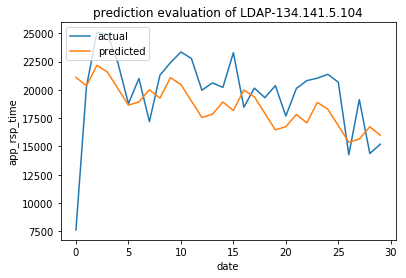

In [10]:
    from matplotlib import pyplot as plt
    plt.plot(prophet_df['y'])
    plt.plot(prophet_df['yhat'])
    plt.title('prediction evaluation of '+a+'-'+s)
    plt.ylabel('app_rsp_time')
    plt.xlabel('date')
    plt.legend([ 'actual','predicted'], loc='upper left')
    plt.show()

## XGBoost Model

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

delay_pred function is used to make history date with specified delay.

In [11]:
def delay_pred(dataset,delay):
    dataset2 = dataset.copy()
    colnames = (dataset.columns)
    for i in range((delay),len(dataset)):
        
        for j in range(0,len(colnames)):
            colmn1 = colnames[j]
            if(colmn1 in ['app_rsp_time','hour','weekday','app_rsp_time_t-1']):
                continue
            dataset2[colmn1][i] = dataset.iloc[(i-delay):i,j].mean()
            #dataset2.set_values(i,colmn1, dataset2.iloc[i:(i+delay),j].mean())
    
    return dataset2


forcast_shifter funtion is used to shift the output(app_rsp_time) as per the point to be predicted using the history data , and also it adjust the length of given x & y data after the shifting operation to avoid the na values.

In [12]:
def forcast_shifter(X,y,forcast_lag):

    #X.index = range(len(X))
    #y.index = range(len(y))
    
    y1=y.shift(-forcast_lag)
    #print(X.iloc[0:X.shape[0]-forcast_lag,:])
    X1=X.iloc[0:X.shape[0]-forcast_lag,:].astype('float64')
    y1 = y1[0:len(y1)-forcast_lag]
    return X1,y1

#### XGB prediction function

In [13]:
def  xgb_all_real_24(data_l_ew_g,history_lag=5,forcast_lag=1):
    import numpy as np
    
    data_l_ew_g1 = data_l_ew_g.copy()
    data_l_ew_history = delay_pred(data_l_ew_g1,history_lag)
    
    # Removing the outlier
    #data_l_ew_history.loc[data_l_ew_history['app_rsp_time']==max(data_l_ew_history['app_rsp_time']),'app_rsp_time']= data_l_ew_history['app_rsp_time'].quantile(.9)*.2

    ###### Removing the outlier ######
    #cutter = data_l_ew_history['app_rsp_time'].quantile(.90)
    #data_l_ew_history.loc[data_l_ew_history['app_rsp_time']> cutter,'app_rsp_time']= cutter
    #data_l_ew_history['app_rsp_time'] = (data_l_ew_history['app_rsp_time'])
    
    import random
    import datetime
    
    random.seed(100)
    data_l_ew_history['date'] = data_l_ew_history.index
    data_l_ew_history=data_l_ew_history.sort_values(by='date')
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    cal = calendar()
    holidays = cal.holidays(start = data_l_ew_history.date.min(), end = data_l_ew_history.date.max())
    #data_l_ew_history["IS_HOLIDAY"] = data_l_ew_history.date.isin(holidays)
    #data_l_ew_history["IS_WORKDAY"] = data_l_ew_history.date.apply(lambda x: 0 if x.dayofweek > 5 else 1  )
    import xgboost as xgb
    from sklearn.cross_validation import train_test_split as ttsplit
    from sklearn.datasets import load_boston
    from sklearn.metrics import mean_squared_error as mse

    #--- Model without is_workday and is_holiday ---#
    import numpy as np
    X = data_l_ew_history.iloc[:,1:data_l_ew_history.shape[1]-1].values
    
    y = np.array((data_l_ew_history['app_rsp_time']))
    predicted1 =list()
    split2 = int(len(X)-forcast_lag)#-1
    
    X_test_t = X[split2:len(X),:]
    
    y_test_t = y[split2:len(y)]
    k=24
    
    
    for j in range(1,forcast_lag+1):
        
        #--- Shifting as per required forcast ------
        X1,y1 = forcast_shifter(data_l_ew_history.iloc[:,1:data_l_ew_history.shape[1]-1],
                                data_l_ew_history['app_rsp_time'],j)

        
        X = X1.values
        y = np.array(np.log(y1))
        #y = np.array(y1)
        #y_train,y_test = forcast_shifter
        # split data into training and testing sets
        # then split training set in half
        #X_train, X_test, y_train, y_test = ttsplit(X, y, test_size=0.3, random_state=0)
        #split2 = int(len(X)*.7)
        # lenght of data frame X will reduce when j shift is done 
        #split2 = int(len(X)-(24-j))
        X_train = X[0:(split2-1),:]
        X_test = X[(split2-1):len(X),:]
        y_train = y[0:(split2-1)]
        y_test = y[(split2-1):len(X)]
        xg_train_1 = xgb.DMatrix(X_train, label=y_train)
        #xg_train_2 = xgb.DMatrix(X_train_2, label=y_train_2)
        xg_test = xgb.DMatrix(X_test, label=y_test)
    
        s_time = datetime.datetime.now()

        params = {'objective': 'reg:linear', 'verbose': True , 'eval' : 'rmse ' ,'gamma':.01,
                 'max_depth':3, 'min_child_weight':3,'eta':.02,'num_round':350}
        #params = {  'objective':'reg:linear' , 'verbose': True , 'eval' : 'rmse ' }
        model_1_mean5 = xgb.train(params, xg_train_1, 200)
        e_time = datetime.datetime.now()
        run_time = (e_time - s_time)
        #print((run_time.seconds)/60,"minuts")

        #--- Training and testing rmse finding ---#
    
    
        ### Test set manipulations ###
        predicted_dummy = model_1_mean5.predict(xg_test)
        #print(predicted_dummy)
        predicted1.append(predicted_dummy[0])
        
    
    y_test = (y_test_t)
    predicted1 = np.exp(predicted1)
    
    delta = pd.Series(( y_test - predicted1))
    compar_test = pd.DataFrame({'predicted':predicted1,'actual':y_test,'error':delta})
    compar_test['perc_error']= abs(compar_test['error']/compar_test['actual']*100)
   # xgb_mse_test =(mse(compar_test['predicted'] , compar_test['actual']))
   # xgb_rmse_test = math.sqrt(xgb_mse_test)

    #print('test rmse',xgb_rmse_test )
    
    xgb_mape_test = compar_test.perc_error.mean()
    print('MAPE = ',xgb_mape_test)
    
    q98=compar_test['perc_error'].quantile(0.98)
    mape_q98_test =compar_test['perc_error'][compar_test.perc_error<compar_test['perc_error'].quantile(0.98)].mean()
    print('MAPE clipped at 98% = ',mape_q98_test)
    
    mm ='xgboost_hist'+str(history_lag)+'_forcast_'+str(forcast_lag)
    df = pd.DataFrame({'Model':[mm],#'predicted_t':[forcast_lag],
                         
                         #'test_rmse':[round(xgb_rmse_test,2)],
                         
                         'test_mape':[round(xgb_mape_test,2)],
                       
                       'test_mape_98':[round(mape_q98_test,2)]
                      })
    return df,compar_test

### Running xgboost model for selected application-source model

In [14]:


a = ap_list[0]
s = s_list[0]
xgb_analysis_df_full = pd.DataFrame()

for a in tqdm(ap_list):
    for s in s_list:
        qt1 = datetime.now()
        data = df[(df.application == a ) & (df.source==s)]

        df_t = data.registerTempTable('dummy')
        df_t = sqlContext.sql('select avg(app_rsp_time) as app_rsp_time, time_stamp, avg(byte_count)  as byte_count, avg(flow_count) as flow_count , avg(rx_byte_count) as rx_byte_count , avg(rx_flow_count) as rx_flow_count , avg(tcp_rsp_time) as tcp_rsp_time , avg(tx_byte_count) as tx_byte_count , avg(tx_flow_count) as tx_flow_count from dummy group by source, application, time_stamp')


        # data cleaning
        df_t = df_t[df_t.app_rsp_time!=0]
        app_rsp_time_df=df_t.toPandas() 

   
        app_rsp_time_df = app_rsp_time_df.sort_values(by='app_rsp_time',ascending=True)       
        dates_outlook = pd.to_datetime(pd.Series(app_rsp_time_df.time_stamp),unit='ms')
        app_rsp_time_df.index = dates_outlook   
        app_rsp_time_df = app_rsp_time_df.sort_values(by='time_stamp')

        app_rsp_time_df['date'] = app_rsp_time_df.index.date
        del app_rsp_time_df['time_stamp']

        app_rsp_time_df = app_rsp_time_df.reset_index()
        weekday = app_rsp_time_df.time_stamp.dt.weekday
        app_rsp_time_df['weekday'] = weekday
        del app_rsp_time_df['time_stamp']

        app_rsp_time_df = pd.DataFrame(app_rsp_time_df.groupby(by='date')['app_rsp_time','byte_count','flow_count','rx_byte_count','rx_flow_count', 'tcp_rsp_time', 'tx_byte_count', 'tx_flow_count','weekday'].max())

        analyse_df,compare_test=xgb_all_real_24(app_rsp_time_df,5,30)
        xgb_analysis_df_full = xgb_analysis_df_full.append(analyse_df)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


MAPE =  15.326161609231917
MAPE clipped at 98% =  13.690980571354732


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
 20%|██        | 1/5 [01:57<07:48, 117.24s/it]

MAPE =  57.7113460240155
MAPE clipped at 98% =  46.440049331084964


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)


MAPE =  25.323578411042167
MAPE clipped at 98% =  23.32020976773893


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
 40%|████      | 2/5 [03:50<05:48, 116.11s/it]

MAPE =  78.44924201496868
MAPE clipped at 98% =  60.648104639555314


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)


MAPE =  128.00778492373072
MAPE clipped at 98% =  92.95505590143878


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
 60%|██████    | 3/5 [05:41<03:49, 114.55s/it]

MAPE =  133.3276753830664
MAPE clipped at 98% =  110.57769295068856


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)


MAPE =  29.37798533973058
MAPE clipped at 98% =  28.423986711012542


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
 80%|████████  | 4/5 [07:32<01:53, 113.50s/it]

MAPE =  28.688922547792142
MAPE clipped at 98% =  26.83422518874974


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)


MAPE =  29.23672178007612
MAPE clipped at 98% =  28.46652674799415


/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)
100%|██████████| 5/5 [09:25<00:00, 113.15s/it]

MAPE =  22.863278702949852
MAPE clipped at 98% =  21.372810345918722


It takes 56 seconds to run for an individual combination.

In [15]:
xgb_analysis_df_full

,Model,test_mape,test_mape_98
0,xgboost_hist5_forcast_30,15.33,13.69
0,xgboost_hist5_forcast_30,57.71,46.44
0,xgboost_hist5_forcast_30,25.32,23.32
0,xgboost_hist5_forcast_30,78.45,60.65
0,xgboost_hist5_forcast_30,128.01,92.96
0,xgboost_hist5_forcast_30,133.33,110.58
0,xgboost_hist5_forcast_30,29.38,28.42
0,xgboost_hist5_forcast_30,28.69,26.83
0,xgboost_hist5_forcast_30,29.24,28.47
0,xgboost_hist5_forcast_30,22.86,21.37


### evaluation example 

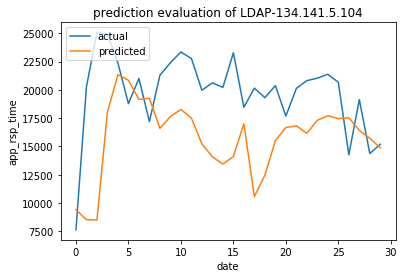

In [17]:
    from matplotlib import pyplot as plt
    plt.plot(compare_test['actual'])
    plt.plot(compare_test['predicted'])
    plt.title('prediction evaluation of '+a+'-'+s)
    plt.ylabel('app_rsp_time')
    plt.xlabel('date')
    plt.legend([ 'actual','predicted'], loc='upper left')
    plt.show()

## LSTM Model

In [18]:
from keras.layers.embeddings  import  Embedding
from keras.layers import LSTM,Dropout
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.callbacks import TensorBoard
from time import time

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [19]:
def lstm_shifter(y,forcast_lag):
    
    y1=y.shift(-forcast_lag)    
    y1 = y1[0:len(y1)-forcast_lag]
    return y1

In [20]:
import math 
from sklearn.metrics import mean_squared_error
from tensorflow import set_random_seed


def lstm_new(data_l_ew_g_lstm,lag):
    
    
    #data_l_ew_g_lstm = data_l_ew_g_lstm.iloc[:,0:13].copy()
    data_l_ew_g_lstm1 = data_l_ew_g_lstm.copy()
    cols = data_l_ew_g_lstm.columns
    
    ###### Removing the outlier ######
    #cutter = data_l_ew_g_lstm['app_rsp_time'].quantile(.90)
    #data_l_ew_g_lstm.loc[data_l_ew_g_lstm['app_rsp_time']> cutter,'app_rsp_time']= cutter
    #data_l_ew_g_lstm['app_rsp_time'] = np.log(data_l_ew_g_lstm['app_rsp_time'])
    
    

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_l_ew_g_lstm = pd.DataFrame(scaler.fit_transform(data_l_ew_g_lstm))


    import numpy as np
    #X_lstm = pd.concat([data_l_ew_history.iloc[:,1:13],data_l_ew_history.iloc[:,14:16]],axis=1)#.values
    X_lstm = data_l_ew_g_lstm.iloc[:,1:len(cols)]
    y_lstm_init = pd.DataFrame(data_l_ew_g_lstm.iloc[:,0])
    
    y_output = pd.DataFrame()
    
    for i in range(1,(lag+1)):
        name_z='y'+str(i)
        ff =lstm_shifter(y_lstm_init,i)
        
        #y_output[name_z]=list(ff.iloc[0:len(ff)-(lag-1-i),0])
        y_output[name_z]=list(ff.iloc[0:len(X_lstm)-(lag),0])
        
    
    y_lstm1= y_output.copy()
    X_lstm1 = X_lstm.copy()

    

    split = int(len(y_lstm1)-(lag))
    #train_x = X_lstm1.iloc[0:split-(lag-1),:].values
    #test_x = X_lstm1.iloc[(split-lag):(split-1),:].values
    
    train_x = X_lstm1.iloc[0:split,:].values
    test_x = X_lstm1.iloc[split:len(y_lstm1),:].values
    

    #train_y = y_lstm1.iloc[0:split-(lag-1),:].values
    #test_y = y_lstm1.iloc[(split-lag):(split-1),:].values
    train_y = y_lstm1.iloc[0:split,:].values
    test_y = y_lstm1.iloc[split:len(y_lstm1),:].values

    train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])

    set_random_seed(7)    
    model_m2=Sequential()
    model_m2.add(LSTM(12, dropout=0.2,input_shape=(1,len(cols)-1),
                  batch_input_shape=(1, train_x.shape[1], train_x.shape[2]), stateful=True))
    model_m2.add(Dense(6, activation='relu'))
    model_m2.add(Dropout(0.2))
    model_m2.add(Dense(3, activation='relu'))
    model_m2.add(Dropout(0.1))
    model_m2.add(Dense(lag, activation='relu'))
    model_m2.summary()
    
    model_m2.compile(optimizer='rmsprop',
                  loss='mse')

    r_lstm = model_m2.fit(train_x, train_y, epochs=10, batch_size=1,verbose=2 ,
                          validation_data=(test_x,test_y) , shuffle=False)


        
    # make predictions
    trainPredict = model_m2.predict(train_x,batch_size=1)
    testPredict = model_m2.predict(test_x,batch_size=1)
    
     # Invert predictions
    p_table0 = pd.concat( [pd.DataFrame(list(trainPredict[(len(trainPredict)-1)])).reset_index(drop=True),X_lstm.iloc[(split-lag):(split),0:13].reset_index(drop=True)],axis =1)
    r_table0 = pd.concat( [pd.DataFrame(list(train_y[(len(train_y)-1)])).reset_index(drop=True),X_lstm.iloc[(split-lag):(split),0:13].reset_index(drop=True)],axis =1)

    r_table1 = pd.DataFrame(scaler.inverse_transform(r_table0))
    #r_table1 = r_table1.iloc[0:split,:]
    p_table1 = pd.DataFrame(scaler.inverse_transform(p_table0))

    tt1 = X_lstm.iloc[(split):(len(X_lstm)),0:len(cols)]
    #tt1.set_index(tt.index)
    tt1['app_rsp']=list(testPredict[(len(testPredict)-1)])
    cols = tt1.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    p_table_test0 = tt1[cols]
    #p_table0 = p_table.dropna()
    p_table_test0.head()

    tt1 = X_lstm.iloc[(split):(len(X_lstm)),0:len(cols)]
    #tt1.set_index(tt.index)
    tt1['app_rsp']=list(test_y[(len(test_y)-1)])
    cols = tt1.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    r_table_test0 = tt1[cols]
    #p_table0 = p_table.dropna()
    r_table_test0.head()

    # invert predictions
    r_table_test = pd.DataFrame(scaler.inverse_transform(r_table_test0))
    #r_table1 = r_table0.iloc[0:split,:]
    p_table_test = pd.DataFrame(scaler.inverse_transform(p_table_test0))
    
    ### Train and test mape finding 
    
    
    compare_train  = pd.DataFrame({'train_real':r_table1.iloc[:,0],
                                   'train_pred':p_table1.iloc[:,0]})
    compare_train['error'] = abs(compare_train['train_real'] - compare_train['train_pred'])
    compare_train['perc_error'] = compare_train['error']/compare_train['train_real']*100
    lstm_mape_train = compare_train.perc_error.mean()
    print('MAPE of train = ',lstm_mape_train)
    lstm_rmse_train = math.sqrt(mean_squared_error(compare_train['train_real'], compare_train['train_pred']))
    print("rmse of train = ",lstm_rmse_train)

    compare_test  = pd.DataFrame({'test_real':r_table_test.iloc[:,0],
                                   'test_pred':p_table_test.iloc[:,0]})
    compare_test['error'] = abs(compare_test['test_real'] - compare_test['test_pred'])
    compare_test['perc_error'] = compare_test['error']/compare_test['test_real']*100
    lstm_mape_test = compare_test.perc_error.mean()
    print('MAPE of test = ',lstm_mape_test)
    lstm_rmse_test = math.sqrt(mean_squared_error(compare_test['test_real'], compare_test['test_pred']))
    print("rmse of test = ",lstm_rmse_test)
    
    q98=compare_test['perc_error'].quantile(0.98)
    mape_q98_test =compare_test['perc_error'][compare_test.perc_error<compare_test['perc_error'].quantile(0.98)].mean()
    
    
    #mm ='lstm'
    df = pd.DataFrame({#'Model':[mm],#'predicted_t':[forcast_lag],
                        #'clipped_point':[round(clipped,2)],
                         
                         'train_rmse':[round(lstm_rmse_train,2)],
                         'test_rmse':[round(lstm_rmse_test,2)],
                         'train_mape':[round(lstm_mape_train,2)],
                         'test_mape':[round(lstm_mape_test,2)],
                       #'train_mape_98':[round(lstm_q98,2)],
                       'test_mape_98':[round(mape_q98_test,2)]
                      })
    return df,compare_train,compare_test,r_lstm
    


In [21]:
from sklearn.preprocessing import RobustScaler

def lstm_wt_new1(data_l_ew_g_lstm,lag):
    
    #take all input except date column
    #data_l_ew_g_lstm = data_l_ew_g_lstm.iloc[:,0:13].copy()
    data_l_ew_g_lstm1 = data_l_ew_g_lstm.copy()
    cols = data_l_ew_g_lstm.columns
    
    ###### Removing the outlier ######
    #cutter = data_l_ew_g_lstm['app_rsp_time'].quantile(.90)
    #data_l_ew_g_lstm.loc[data_l_ew_g_lstm['app_rsp_time']> cutter,'app_rsp_time']= cutter
    #data_l_ew_g_lstm['app_rsp_time'] = np.log(data_l_ew_g_lstm['app_rsp_time'])
    
    #filter all inputs except 'app_rsp_time','weekday','hour','byte_count'
#    for c in data_l_ew_g_lstm.columns:
#        if(c in ['app_rsp_time','weekday','hour','byte_count']):
#            continue
#        y1=deno_filter(data_l_ew_g_lstm[c])
#        if(len(y1)!=len(data_l_ew_g_lstm)):
#            y1 = deno_filter1(data_l_ew_g_lstm[c])
#        data_l_ew_g_lstm[c]=y1

    # normalize the dataset
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler1=RobustScaler(quantile_range=(5,95))
    scaler2=RobustScaler(quantile_range=(5,95))
    #data_l_ew_g_lstm = pd.DataFrame(scaler.fit_transform(data_l_ew_g_lstm))


    import numpy as np
    #X_lstm = pd.concat([data_l_ew_history.iloc[:,1:13],data_l_ew_history.iloc[:,14:16]],axis=1)#.values
    X_lstm = data_l_ew_g_lstm.iloc[:,1:len(cols)]
    y_lstm_init = pd.DataFrame(data_l_ew_g_lstm.iloc[:,0])
    
    y_output = pd.DataFrame()
    
    for i in range(1,(lag+1)):
        name_z='y'+str(i)
        ff =lstm_shifter(y_lstm_init,i)
        
        #y_output[name_z]=list(ff.iloc[0:len(ff)-(lag-1-i),0])
        y_output[name_z]=list(ff.iloc[0:len(X_lstm)-(lag),0])
        
    
    y_lstm1= y_output.copy()
    X_lstm1 = X_lstm.copy()

    

    split = int(len(y_lstm1)-(lag))
    #train_x = X_lstm1.iloc[0:split-(lag-1),:].values
    #test_x = X_lstm1.iloc[(split-lag):(split-1),:].values
    
    train_x = X_lstm1.iloc[0:split,:].values
    test_x = X_lstm1.iloc[split:len(y_lstm1),:].values
    

    #train_y = y_lstm1.iloc[0:split-(lag-1),:].values
    #test_y = y_lstm1.iloc[(split-lag):(split-1),:].values
    train_y = y_lstm1.iloc[0:split,:].values
    test_y = y_lstm1.iloc[split:len(y_lstm1),:].values
    
    # Normalisijng using robust scaler
    scaler1 = scaler1.fit(train_x) 
    train_x = scaler1.transform(train_x)
    test_x = scaler1.transform(test_x)
    
    scaler2 = scaler2.fit(train_y) 
    train_y = scaler2.transform(train_y)
    test_y = scaler2.transform(test_y)

    train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])

    
        
    model_m2=Sequential()
    model_m2.add(LSTM(12, dropout=0.2,input_shape=(1,len(cols)-1),
                  batch_input_shape=(1, train_x.shape[1], train_x.shape[2]), stateful=True))
    model_m2.add(Dense(8, activation='relu'))
    model_m2.add(Dropout(0.2))
    model_m2.add(Dense(6, activation='relu'))
    model_m2.add(Dropout(0.1))
    model_m2.add(Dense(lag, activation='relu'))
    model_m2.summary()
    
    model_m2.compile(optimizer='rmsprop',
                  loss='mse')
    
    

    r_lstm = model_m2.fit(train_x, train_y, epochs=10, batch_size=1,verbose=2 ,
                          validation_data=(test_x,test_y) , shuffle=False)

    model_m2.reset_states()
   
    
    # make predictions
    trainPredict = model_m2.predict(train_x,batch_size=1)
    testPredict = model_m2.predict(test_x,batch_size=1)
        
    
    
    # Invert predictions
    
    trainPredict1 = scaler2.inverse_transform(trainPredict)
    testPredict1 = scaler2.inverse_transform(testPredict)
    train_y1 = scaler2.inverse_transform(train_y)
    test_y1 = scaler2.inverse_transform(test_y)
    
    
    
    ### Train and test mape finding 
    
    
    compare_train  = pd.DataFrame({'actual':list(train_y1[(len(train_y1)-1)]),
                                   'predicted':list(trainPredict1[(len(trainPredict1)-1)])})
    compare_train['error'] = abs(compare_train['actual'] - compare_train['predicted'])
    compare_train['perc_error'] = compare_train['error']/compare_train['actual']*100
    lstm_mape_train = compare_train.perc_error.mean()
    print('MAPE of train = ',lstm_mape_train)
    lstm_rmse_train = math.sqrt(mean_squared_error(compare_train['actual'], compare_train['predicted']))
    print("rmse of train = ",lstm_rmse_train)

    compare_test  = pd.DataFrame({'actual':list(test_y1[(len(test_y1)-1)]),
                                   'predicted':list(testPredict1[(len(testPredict1)-1)])})
    compare_test['error'] = abs(compare_test['actual'] - compare_test['predicted'])
    compare_test['perc_error'] = compare_test['error']/compare_test['actual']*100
    lstm_mape_test = compare_test.perc_error.mean()
    print('MAPE of test = ',lstm_mape_test)
    lstm_rmse_test = math.sqrt(mean_squared_error(compare_test['actual'], compare_test['predicted']))
    print("rmse of test = ",lstm_rmse_test)
    
    q98=compare_test['perc_error'].quantile(0.98)
    mape_q98_test =compare_test['perc_error'][compare_test.perc_error<compare_test['perc_error'].quantile(0.98)].mean()
    
    
    #mm ='lstm'
    df = pd.DataFrame({#'Model':[mm],#'predicted_t':[forcast_lag],
                        #'clipped_point':[round(clipped,2)],
                         
                         'train_rmse':[round(lstm_rmse_train,2)],
                         'test_rmse':[round(lstm_rmse_test,2)],
                         'train_mape':[round(lstm_mape_train,2)],
                         'test_mape':[round(lstm_mape_test,2)],
                       #'train_mape_98':[round(lstm_q98,2)],
                       'test_mape_98':[round(mape_q98_test,2)]
                      })
    return df,compare_train,compare_test,r_lstm

### Running lstm model for selected application-source model

In [26]:


a = ap_list[0]
s = s_list[0]
lstm_analysis_df_full = pd.DataFrame()

for a in tqdm(ap_list):
    for s in s_list:
        qt1 = datetime.now()
        data = df[(df.application == a ) & (df.source==s)]

        df_t = data.registerTempTable('dummy')
        df_t = sqlContext.sql('select avg(app_rsp_time) as app_rsp_time, time_stamp, avg(byte_count)  as byte_count, avg(flow_count) as flow_count , avg(rx_byte_count) as rx_byte_count , avg(rx_flow_count) as rx_flow_count , avg(tcp_rsp_time) as tcp_rsp_time , avg(tx_byte_count) as tx_byte_count , avg(tx_flow_count) as tx_flow_count from dummy group by source, application, time_stamp')


        # data cleaning
        df_t = df_t[df_t.app_rsp_time!=0]
        app_rsp_time_df=df_t.toPandas() 

   
        app_rsp_time_df = app_rsp_time_df.sort_values(by='app_rsp_time',ascending=True)       
        dates_outlook = pd.to_datetime(pd.Series(app_rsp_time_df.time_stamp),unit='ms')
        app_rsp_time_df.index = dates_outlook   
        app_rsp_time_df = app_rsp_time_df.sort_values(by='time_stamp')

        app_rsp_time_df['date'] = app_rsp_time_df.index.date
        del app_rsp_time_df['time_stamp']

        app_rsp_time_df = app_rsp_time_df.reset_index()
        weekday = app_rsp_time_df.time_stamp.dt.weekday
        app_rsp_time_df['weekday'] = weekday
        del app_rsp_time_df['time_stamp']

        app_rsp_time_df = pd.DataFrame(app_rsp_time_df.groupby(by='date')['app_rsp_time','byte_count','flow_count','rx_byte_count','rx_flow_count', 'tcp_rsp_time', 'tx_byte_count', 'tx_flow_count','weekday'].max())

        analyse_df,comare_train,compare_test,history=lstm_wt_new1(app_rsp_time_df,30)
        lstm_analysis_df_full = lstm_analysis_df_full.append(analyse_df)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:138: DeprecationWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  "Deprecated in 2.0, use createOrReplaceTempView instead.", DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 12)                   1008      
_________________________________________________________________
dense_4 (Dense)              (1, 8)                    104       
_________________________________________________________________
dropout_3 (Dropout)          (1, 8)                    0         
_________________________________________________________________
dense_5 (Dense)              (1, 6)                    54        
_________________________________________________________________
dropout_4 (Dropout)          (1, 6)                    0         
_________________________________________________________________
dense_6 (Dense)              (1, 30)                   210       
Total params: 1,376
Trainable params: 1,376
Non-trainable params: 0
_________________________________________________________________
Train on

 20%|██        | 1/5 [01:10<04:43, 70.96s/it]

MAPE of train =  446.3224744591964
rmse of train =  34652.58786660205
MAPE of test =  129.02574273761294
rmse of test =  28323.616632111614
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 12)                   1008      
_________________________________________________________________
dense_10 (Dense)             (1, 8)                    104       
_________________________________________________________________
dropout_7 (Dropout)          (1, 8)                    0         
_________________________________________________________________
dense_11 (Dense)             (1, 6)                    54        
_________________________________________________________________
dropout_8 (Dropout)          (1, 6)                    0         
_________________________________________________________________
dense_12 (Dense)             (1, 30)                   210       
To

 40%|████      | 2/5 [02:17<03:28, 69.55s/it]

MAPE of train =  32.31559330963227
rmse of train =  28024.218126822692
MAPE of test =  132.97792920822977
rmse of test =  35743.41591221252
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 12)                   1008      
_________________________________________________________________
dense_16 (Dense)             (1, 8)                    104       
_________________________________________________________________
dropout_11 (Dropout)         (1, 8)                    0         
_________________________________________________________________
dense_17 (Dense)             (1, 6)                    54        
_________________________________________________________________
dropout_12 (Dropout)         (1, 6)                    0         
_________________________________________________________________
dense_18 (Dense)             (1, 30)                   210       
To

 60%|██████    | 3/5 [03:23<02:17, 68.51s/it]

MAPE of train =  417.4971634429952
rmse of train =  334162.2520204678
MAPE of test =  310.1454695822596
rmse of test =  285537.44519962656
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (1, 12)                   1008      
_________________________________________________________________
dense_22 (Dense)             (1, 8)                    104       
_________________________________________________________________
dropout_15 (Dropout)         (1, 8)                    0         
_________________________________________________________________
dense_23 (Dense)             (1, 6)                    54        
_________________________________________________________________
dropout_16 (Dropout)         (1, 6)                    0         
_________________________________________________________________
dense_24 (Dense)             (1, 30)                   210       
Tot

 80%|████████  | 4/5 [04:31<01:08, 68.41s/it]

MAPE of train =  49.738542265189366
rmse of train =  15856.789475251604
MAPE of test =  32.733902527942774
rmse of test =  19031.79950612703
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (1, 12)                   1008      
_________________________________________________________________
dense_28 (Dense)             (1, 8)                    104       
_________________________________________________________________
dropout_19 (Dropout)         (1, 8)                    0         
_________________________________________________________________
dense_29 (Dense)             (1, 6)                    54        
_________________________________________________________________
dropout_20 (Dropout)         (1, 6)                    0         
_________________________________________________________________
dense_30 (Dense)             (1, 30)                   210       
T

100%|██████████| 5/5 [05:41<00:00, 68.93s/it]

MAPE of train =  28.34652141341763
rmse of train =  6431.2775783095085
MAPE of test =  35.94626403144103
rmse of test =  6877.350481467575


It takes 32 seconds to run for an individual combination .

In [27]:
lstm_analysis_df_full

,train_rmse,test_rmse,train_mape,test_mape,test_mape_98
0,4323.77,13987.54,5.90,13.59,12.28
0,34652.59,28323.62,446.32,129.03,28.39
0,32685.27,5003.89,24.53,23.65,21.72
0,28024.22,35743.42,32.32,132.98,106.65
0,133101.31,208232.72,106.32,141.37,115.21
0,334162.25,285537.45,417.50,310.15,279.31
0,9087.06,31370.19,9.47,20.99,20.02
0,15856.79,19031.80,49.74,32.73,17.54
0,15607.92,30746.06,15.92,31.93,31.43
0,6431.28,6877.35,28.35,35.95,29.14


#### loss

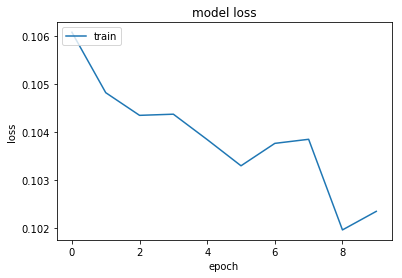

In [24]:
    from matplotlib import pyplot as plt
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

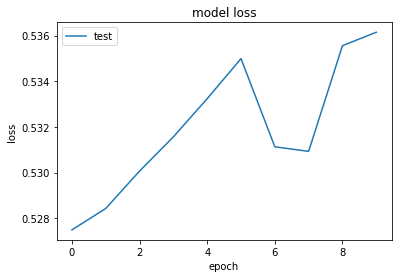

In [25]:
    from matplotlib import pyplot as plt
    #plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([ 'test'], loc='upper left')
    plt.show()

### evaluation example 

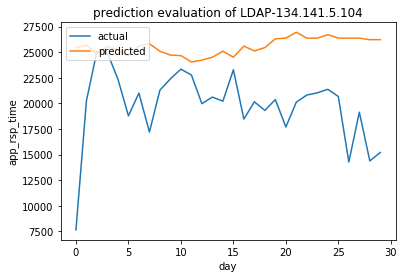

In [28]:
    from matplotlib import pyplot as plt
    plt.plot(compare_test['actual'])
    plt.plot(compare_test['predicted'])
    plt.title('prediction evaluation of '+a+'-'+s)
    plt.ylabel('app_rsp_time')
    plt.xlabel('day')
    plt.legend([ 'actual','predicted'], loc='upper left')
    plt.show()

#### median of lstm ,xgb and prophet model's test

In [43]:
lstm_analysis_df_full.test_mape.quantile(.5) ,xgb_analysis_df_full.test_mape.quantile(.5),prophet_analysis_df_full.test_mape.quantile(.5)

(34.34, 29.31, 52.089266699460445)

## comparing of 3 models

#### test_mape

In [47]:
mape_analysis_df = pd.DataFrame()
mape_analysis_df['application']=prophet_analysis_df_full.application

l=[]
for i in range(0,5):
    l.append('10.6.1.101')
    l.append('134.141.5.104')

mape_analysis_df['source'] = l
mape_analysis_df.index = range(len(mape_analysis_df))
prophet_analysis_df_full.index = range(len(prophet_analysis_df_full))
mape_analysis_df['prophet_mape'] = prophet_analysis_df_full.test_mape
lstm_analysis_df_full.index = range(len(lstm_analysis_df_full))
mape_analysis_df['lstm_mape'] = lstm_analysis_df_full.test_mape
xgb_analysis_df_full.index = range(len(xgb_analysis_df_full))
mape_analysis_df['xgb_mape'] = xgb_analysis_df_full.test_mape

mape_analysis_df

,application,source,prophet_mape,lstm_mape,xgb_mape
0,DNS,10.6.1.101,9.901298,13.59,15.33
1,DNS,134.141.5.104,167.166154,129.03,57.71
2,DHCP,10.6.1.101,22.045480,23.65,25.32
3,DHCP,134.141.5.104,231.868319,132.98,78.45
4,Radius,10.6.1.101,246.801582,141.37,128.01
5,Radius,134.141.5.104,453.165254,310.15,133.33
6,Kerberos,10.6.1.101,21.677883,20.99,29.38
7,Kerberos,134.141.5.104,82.133054,32.73,28.69
8,LDAP,10.6.1.101,19.043158,31.93,29.24
9,LDAP,134.141.5.104,16.693480,35.95,22.86


In [48]:
mape_analysis_df.prophet_mape.describe()

count     10.000000
mean     127.049566
std      147.196923
min        9.901298
25%       19.701839
50%       52.089267
75%      215.692778
max      453.165254
Name: prophet_mape, dtype: float64

In [49]:
mape_analysis_df.lstm_mape.describe()

count     10.000000
mean      87.237000
std       93.675415
min       13.590000
25%       25.720000
50%       34.340000
75%      131.992500
max      310.150000
Name: lstm_mape, dtype: float64

In [50]:
mape_analysis_df.xgb_mape.describe()

count     10.000000
mean      54.832000
std       44.124549
min       15.330000
25%       26.162500
50%       29.310000
75%       73.265000
max      133.330000
Name: xgb_mape, dtype: float64

#### runtime

In [51]:
runtime_analysis_df = pd.DataFrame({'model':['prophet','lstm','xgb'],
                                    'runtime_for_10_combination':['3.18 min','5.41 min','9.25 min']})

runtime_analysis_df


,model,runtime_for_10_combination
0,prophet,3.18 min
1,lstm,5.41 min
2,xgb,9.25 min
